## Wprowadzenie
W tym notebooku będziemy używać StableBeluga2 modelu opensource podobnego do ChatGPT.


**Uwaga** Aby używać modelu trzeba zmienić runtime na GPU.

## Instalacje

Zanim przejdziemy dalej, musimy upewnić się, że niezbędne biblioteki są zainstalowane:
- `Hugging Face Transformers`: Zapewnia nam prosty sposób na wykorzystanie wstępnie wytrenowanych modeli.
- `PyTorch`: Służy jako szkielet dla operacji głębokiego uczenia.
- `Accelerate`: Optymalizuje operacje PyTorch, zwłaszcza na GPU.

In [ ]:
!pip install transformers torch accelerate sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.7 MB/s eta 0:00:00


### Ładowanie modelu i tokenizera

Tutaj przygotowujemy naszą sesję, ładując zarówno model StableBeluga2, jak i powiązany z nim tokenizer.

Tokenizer pomoże w konwersji naszych podpowiedzi tekstowych do formatu, który model może zrozumieć i przetworzyć.

In [ ]:
from transformers import AutoTokenizer
import transformers
import torch

model = "stabilityai/StableBeluga2" # StableBeluga2 to Llama2 finetunowana na zbiorze Orca
# meta-llama/Llama-2-7b-hf

tokenizer = AutoTokenizer.from_pretrained(model)

In [ ]:
tokenizer.tokenize("siała baba mak")

['▁sia', 'ła', '▁b', 'aba', '▁mak']

### Creating the Llama Pipeline

Stworzymy pipeline HuggingFace do generowania tekstu.

*Uwaga*: Wczytywanie modelu może zająć 2-3 minuty

In [ ]:
import torch
from transformers import AutoModelForTokenClassification, AutoModelForCausalLM, AutoTokenizer, pipeline

Wczytujemy odpowiedni model i tokenizer.


In [ ]:
model_name = "stabilityai/StableBeluga-7B"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("stabilityai/StableBeluga-7B", use_fast=False)
model = AutoModelForCausalLM.from_pretrained("stabilityai/StableBeluga-7B", torch_dtype=torch.float16, low_cpu_mem_usage=True, device_map="auto")

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

W celu skorzystania z wczytanego modelu, stworzyliśmy funkcję generate_response().

generate_response() służy do generowania odpowiedzi na postawie podanego tekstu.

W metodzie model.generate() podajemy kilka parametrów:
- `do_sample=True` - oznacza, że modele powinny próbować różnych opcji generowania tekstu
- `top_p=0.95` i `top_k=0` kontrolują, jakie tokeny są dozwolone podczas generowania,
- `top_p` kontroluje, na ile model może być kreatywny, a na ile ma korzystać z najbardziej prawdopodobnych odpowiedzi,
- `top_k` kontroluje, ile tokenów jest dozwolonych
- `max_new_tokens=256` ogranicza generowany tekst do 256 nowych tokenów.



In [ ]:
def generate_response(text):
   # podziel tekst na jednostki, z którymi model jest w stanie pracować, następnie skonwertuj dane na tensor i przenieś na GPU
  inputs = tokenizer(text, return_tensors="pt").to("cuda")
  # Wygeneruj odpowiedź przy pomocy modelu
  output = model.generate(**inputs, do_sample=True, top_p=0.95, top_k=0, max_new_tokens=256)
  # zdekoduj odpowiedź na czytelny tekst
  return tokenizer.decode(output[0], skip_special_tokens=True)

Wykorzystajmy generate_response() do wygenerowania żartu.

In [ ]:
generate_response("Tell me a joke")


'Tell me a joke I should know\nIn doing my job, I\'m lucky enough to do the occasional stand-up comedy gig. As part of that, I get to talk to a lot of other comedians. As you might imagine, my comedian friends are really funny.\nI asked one comedian to give me a "joke" that I\'d likely know because it\'s so popular in the comic world, but I personally would not know it. I\'ll keep the name of the comedian I asked to myself for now.\nThe joke in question is a bit long, but here\'s the gag (including the punchline):\n"Imagine you\'re at a party and you need to use the restroom, but there are no stalls, just urinals. So, you use one of the urinals, and as you\'re doing your business, you hear the most incredible sound coming from the restroom. It\'s a sound that you\'ve never heard before, and it\'s so intriguing, that you just can\'t stop thinking about it.\nNow, all of a sudden, you hear a knock at the door, and before'

A teraz sprawdźmy, jakiego języka programowania powinniśmy się uczyć poza Pythonem według modelu.

In [ ]:
prompt = """I'm a programmer and Python is my favorite language because of it's simple syntax and variety of applications I can build with it.\
Based on that, what language should I learn next?\
Give me 5 recommendations"""
generate_response(prompt)

"I'm a programmer and Python is my favorite language because of it's simple syntax and variety of applications I can build with it.Based on that, what language should I learn next?Give me 5 recommendations.\nPython is a versatile language with a large and growing community. Many people suggest learning other programming languages to expand your skillset and exposure to different development paradigms. So, here are 5 recommendations for programming languages to learn next:\nJava: Java is a popular and widely used general-purpose programming language. It runs on multiple platforms and offers features like garbage collection, which makes it ideal for developing enterprise applications.\nC++: C++ is a general-purpose programming language with low-level features that make it well-suited for system programming and game development. It has a large and supportive community.\nJavaScript: Ascripting language, JavaScript is an essential language for building interactive web applications with mode

# Zadania

Waszym zadaniem jest użycie modelu do 3 nowych zadań:
- analizy sentymentu,
- wykrywania osób z tekstu,
- generowania streszczeń.

W tym celu trzeba stworzyć prompty

Prompt to krótka fraza lub zdanie, które jest używane do rozpoczęcia interakcji z modelem języka lub innym narzędziem NLP.

Możemy w ten sposób użyć modelu do zadań takich jak klasyfikacja

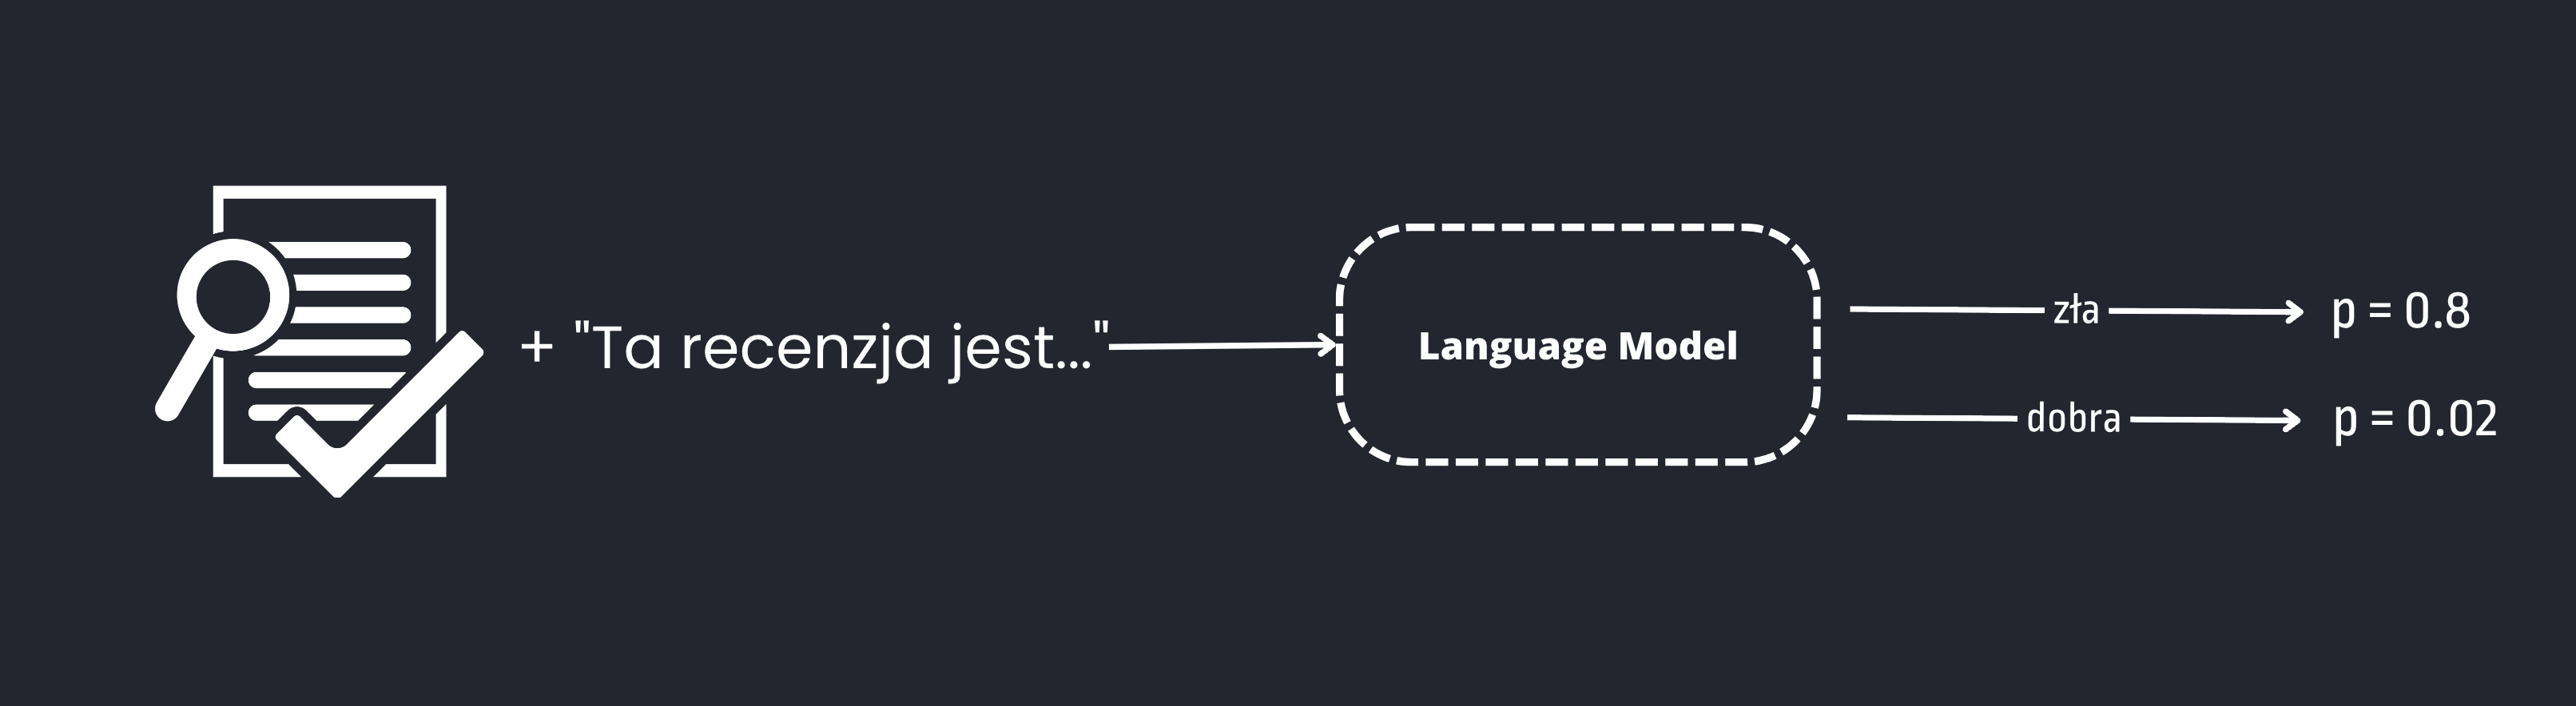

Ale, nie jest to takie proste - modele często lubią nie słuchać się instrukcji, zwracać dodatkowe rzeczy itd.

Trzeba stworzyć odpowiednie instrukcje dla modelu upewnić się że:
* Zwraca odpowiedź w określonym formacie
* Nie halucynuje
* Zwaraca dokładnie to, o co go prosimy

Podpowiedź - aby wydobyć ostateczną odpowiedź z tekstu możemy użyć w pythonie funkcji takich jak `.split()`, `strip()` czy nawet wyrażeń regularnych, aby odpowiednio przyciąć wygenerowany tekst

Skorzystamy ze zbiorów danych dostępnych na HuggingFace w ramach biblioteki datasets.

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00


## 1. Analiza sentymentu

Analiza sentymentu to proces oceny i klasyfikacji emocjonalnego tonu lub nastroju zawartego w tekście, zwłaszcza w tekście pisanych przez ludzi. Celem analizy sentymentu jest określenie, czy tekst wyraża pozytywne, negatywne lub neutralne uczucia lub emocje. Analiza sentymentu jest szeroko stosowana w dziedzinie przetwarzania języka naturalnego (NLP) i ma wiele zastosowań, w tym w monitorowaniu opinii klientów, analizie mediów społecznościowych, badaniach rynkowych i innych obszarach.

W celu zbadania analizy sentymentu, musimy stworzyć model, który przewiduje 2 klasy - `positive` i `negative`, a następnie porównać odpowiedź zwróconą przez model z poprawną odpowiedzią (`label`).

Do zadania wykorzystamy zbiór recenzji filmów z serwisu imdb.

In [ ]:
from datasets import load_dataset
dataset = load_dataset("imdb")

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

jako, że nie będziemy dotrenowywać modelu możemy skorzysać z podzbioru test

Zobaczmy, jak wygląda przykładowa recenzja. Jak myślisz, jaki ma sentyment?

In [ ]:
dataset["test"][:100]["text"][0]

'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as they have

Recenzja ma charakter negatywny - label 0.

In [ ]:
dataset["test"][:100]["label"][0]

0

### Zadanie:
* Stwórz odpowiedni prompt który na podstawie podanej recenzji zaklasyfikuje ją jako pozytywną albo negatywną
* Użyj co najmniej 10 przykładów ze zbioru, aby przetestować model
* Porównaj odpowiedzi modelu z kolumną `label` w datasetcie
* Policz skuteczność

In [ ]:
classifier = pipeline('sentiment-analysis')

texts = dataset["test"][:10]["text"]
labels = dataset["test"][:10]["label"]

correct_predictions = 0

for i in range(10):
    text = texts[i]
    label = labels[i]
    prediction = classifier(text)[0]

    if label == 1 and prediction['label'] == 'POSITIVE':
        correct_predictions += 1
    elif label == 0 and prediction['label'] == 'NEGATIVE':
        correct_predictions += 1

    print("Rzeczywista recenzja:", text)
    print("Rzeczywisa etykieta:", label)
    print("Wygenerowana etykieta:", prediction['label'])
    print("------------------------")

accuracy = correct_predictions / 10
print(f"Skuteczność: {accuracy}")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Rzeczywista recenzja: I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn't match the background, and painfully one-dimensional characters cannot be overcome with a 'sci-fi' setting. (I'm sure there are those of you out there who think Babylon 5 is good sci-fi TV. It's not. It's clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It's really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it's rubbish

## 2. Wykrywanie osób z tekstu

Zadanie NLP polegające na wykrywaniu jednostek nazewniczych z tekstu jest często określane jako "rozpoznawanie jednostek nazewniczych" (NER - Named Entity Recognition). Jest to podzadanie w dziedzinie przetwarzania języka naturalnego, które ma na celu zidentyfikowanie i klasyfikację konkretnych jednostek w tekście, takich jak osoby, miejsca, daty, organizacje itp. W przypadku wykrywania osób, głównym celem jest zidentyfikowanie i klasyfikacja nazwisk, imion i innych informacji związanych z identyfikacją osób.

Daje to możliwość automatycznego wydobywania informacji na temat osób, co może być przydatne w różnych kontekstach, takich jak analiza mediów społecznościowych, anonimizacja danych, eksploracja danych, tworzenie baz danych lub tworzenie systemów do zarządzania informacjami.

https://huggingface.co/datasets/conll2003

In [ ]:
from datasets import load_dataset
dataset = load_dataset("conll2003")

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [ ]:
dataset["test"]

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 3453
})

In [ ]:
dataset["test"][:10]["tokens"][0] # pierwszy przykład

['SOCCER',
 '-',
 'JAPAN',
 'GET',
 'LUCKY',
 'WIN',
 ',',
 'CHINA',
 'IN',
 'SURPRISE',
 'DEFEAT',
 '.']

dataset[

tokenizer.tokenize(

### Zadanie:
* Stwórz odpowiedni prompt który na podstawie podanego tekstu zwróci wszyskie osoby w nim występujące
* Użyj co najmniej 10 przykładów ze zbioru aby przetestować model
* Porównaj odpowiedzi modelu z kolumną `ner_tags` w datasetcie - każde słowo ma swoją etykiete 1,2 oznacza osoby (więcej informacji znajdziesz na stronie datastu w huggingface)
* Policz precyzje i recall używając metryki rouge - https://huggingface.co/spaces/evaluate-metric/rouge jest to specjalna metryka do ekstrakcji informacji

Uwaga: W zbiorze zdania są już podzielone na słowa więc używając tokenizera musimy użyć parametru `is_split_into_words = True`

In [ ]:
tokenizer.tokenize(dataset["test"][:10]["tokens"][0], is_split_into_words = True)

['▁SO',
 'CC',
 'ER',
 '▁-',
 '▁J',
 'AP',
 'AN',
 '▁GET',
 '▁L',
 'U',
 'CK',
 'Y',
 '▁W',
 'IN',
 '▁,',
 '▁CH',
 'IN',
 'A',
 '▁IN',
 '▁S',
 'UR',
 'PRI',
 'SE',
 '▁DE',
 'FE',
 'AT',
 '▁.']

Ale - nasz prompt nie będzie podzielony na słowa więc trzeba stworzyć nową funkcję `generate_response()`, która będzie łączyć dwa zbiory tokenów - te z prompta i te z przykładu

In [ ]:
!pip install Rouge

In [ ]:
from rouge import Rouge

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
model = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
ner_pipeline = pipeline('ner', model=model, tokenizer=tokenizer)

rouge = Rouge()

def generate_response(prompt, example_tokens):
    prompt_tokens = prompt.split()
    combined_tokens = prompt_tokens + example_tokens
    combined_text = " ".join(combined_tokens)
    return combined_text

prompt = "Wykryj osoby w poniższym tekście:"
texts = dataset["test"][:10]["tokens"]
ner_tags = dataset["test"][:10]["ner_tags"]

precision_scores = []
recall_scores = []

for i, example_tokens in enumerate(texts):
    combined_text = generate_response(prompt, example_tokens)
    print(combined_text)

    entities = ner_pipeline(combined_text)

    actual_persons = [token for token, tag in zip(example_tokens, ner_tags[i]) if tag in [1, 2]]
    print("Rzeczywiste osoby:", ' '.join(actual_persons))
    actual_summary = ' '.join(actual_persons)

    predicted_persons = [entity['word'] for entity in entities if entity['entity'] == 'I-PER']
    print("Wykryte osoby:", ' '.join(predicted_persons).replace(" #", "").replace("#", ""))
    predicted_summary = ' '.join(predicted_persons).replace(" #", "").replace("#", "")
    print("----------------")

    if not predicted_summary or not actual_summary:
        continue

    scores = rouge.get_scores(predicted_summary, actual_summary)
    precision_scores.append(scores[0]['rouge-1']['p'])
    recall_scores.append(scores[0]['rouge-1']['r'])

average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)

print("Średni wynik precyzji:", average_precision)
print("Średni wynik recall:", average_recall)

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Wykryj osoby w poniższym tekście: SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRISE DEFEAT .
Rzeczywiste osoby: CHINA
Wykryte osoby: 
----------------
Wykryj osoby w poniższym tekście: Nadim Ladki
Rzeczywiste osoby: Nadim Ladki
Wykryte osoby: Nadim Ladki
----------------
Wykryj osoby w poniższym tekście: AL-AIN , United Arab Emirates 1996-12-06
Rzeczywiste osoby: 
Wykryte osoby: 
----------------
Wykryj osoby w poniższym tekście: Japan began the defence of their Asian Cup title with a lucky 2-1 win against Syria in a Group C championship match on Friday .
Rzeczywiste osoby: 
Wykryte osoby: 
----------------
Wykryj osoby w poniższym tekście: But China saw their luck desert them in the second match of the group , crashing to a surprise 2-0 defeat to newcomers Uzbekistan .
Rzeczywiste osoby: 
Wykryte osoby: 
----------------
Wykryj osoby w poniższym tekście: China controlled most of the match and saw several chances missed until the 78th minute when Uzbek striker Igor Shkvyrin took advanta

## 3. Streszczenia


Sumaryzacja w dziedzinie przetwarzania języka naturalnego (NLP) to proces tworzenia skróconych, zwięzłych wersji dłuższych tekstów, zachowując istotne informacje zawarte w tych tekstach. Głównym celem sumaryzacji jest kompresja tekstu w taki sposób, aby zachować jego znaczenie, a jednocześnie skrócić go, aby można go było łatwiej przeczytać lub zrozumieć. Sumaryzacja jest użyteczna w wielu dziedzinach, takich jak przetwarzanie wiadomości, analiza tekstów, tworzenie spisów treści i wiele innych.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", "3.0.0")

In [ ]:
dataset


### Zadanie
* na podstawie `article` wygenerować streszczenie
* użyj co najmniej 10 przykładów
* ręcznie oceń skuteczność modelu

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
from rouge import Rouge

model = T5ForConditionalGeneration.from_pretrained('t5-base')
tokenizer = T5Tokenizer.from_pretrained('t5-base')

rouge = Rouge()
scores = {'rouge-1': [], 'rouge-2': [], 'rouge-l': []}

for i in range(10):
    article = dataset['test'][i]['article']
    highlights = dataset['test'][i]['highlights']

    inputs = tokenizer.encode(article, return_tensors="pt", max_length=512, truncation=True)
    output = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)

    generated_article = tokenizer.decode(output[0], skip_special_tokens=True)

    print("Rzeczywiste streszczenie:", article)
    print("Wygenerowane streszczenie:", generated_article)
    print("-----------------------------")

    scores_ = rouge.get_scores(generated_article, highlights)[0]
    for key in scores_.keys():
        scores[key].append(scores_[key])

print("Średnie wyniki ROUGE:", scores)

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the

Rzeczywiste streszczenie: (CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body. But Palestinian Foreign Minister Riad al-Malki, speaking a